In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
from scipy.cluster.vq import kmeans as kmeanss
from scipy.cluster.vq import vq as vqs
from sklearn.metrics import confusion_matrix 
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm as detnorm
from matplotlib.ticker import ScalarFormatter
from math import sqrt
import math
import numpy as np
import numpy.linalg as linalg
from random import sample
import csv
import copy
import os
import glob

In [4]:
# for ROC

def ROC (P,T,num,st):
    mini = np.amin(P)
    maxi = np.amax(P)
    inc = (maxi-mini)/num
    n = np.size(P,0)
    m = np.size(P,1)
    TPR = np.zeros(num+2) # change accordingly with inc
    FPR = np.zeros(num+2)
    i = 0
    #print(n)
    for tet in np.arange(mini,maxi+inc,inc):
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for cls in range(m):
            #print(cls)
            for data in range(n):
                if ((T[data] == cls) and (P[data][cls] >= tet)):
                    TP = TP + 1
                if ((T[data] == cls) and (P[data][cls] <= tet)):
                    FN = FN + 1
                if ((T[data] != cls) and (P[data][cls] >= tet)):
                    FP = FP + 1
                if ((T[data] != cls) and (P[data][cls] <= tet)):
                    TN = TN + 1
        TPR[i] = TP/(TP + FN)
        FPR[i] = FP/(FP + TN)   
        i = i + 1
    plt.plot(FPR,TPR)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC for '+st)
    plt.show()

In [5]:
# for pretty plot confusion matrix

from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sn
import warnings


def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
#

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm,st,annot=True, cmap="Oranges", fmt='.2f', fz=20,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 15)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 15)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix for'+st)
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.ylim([len(df_cm), -.5])
    plt.tight_layout()  #set layout slim
    plt.show()
#

def plot_confusion_matrix_from_data(y_test,st,predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=20, lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        whitout a confusion matrix yet
    """
    from sklearn.metrics import confusion_matrix
    from pandas import DataFrame

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    cmap = 'Oranges';
    fz = 20;
    figsize=[9,9];
    show_null_values = 2
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pretty_plot_confusion_matrix(df_cm,st,fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)
#

def the_plot_conf(test,pred,st):
    """ test function with y_test (actual values) and predictions (predic) """
    #data
    warnings.filterwarnings("ignore")
    y_test = np.array(test)
    predic = np.array(pred)
    """
      Examples to validate output (confusion matrix plot)
        actual: 5 and prediction 1   >>  3
        actual: 2 and prediction 4   >>  1
        actual: 3 and prediction 4   >>  10
    """
    columns = []
    annot = True;
    cmap = 'Oranges';
    fmt = '.2f'
    lw = 0.5
    cbar = False
    show_null_values = 2
    pred_val_axis = 'y'
    #size::
    fz = 20;
    figsize = [9,9];
    if(len(y_test) > 10):
        fz=20; figsize=[14,14];
    plot_confusion_matrix_from_data(y_test,st,predic, columns,
      annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)

In [7]:
# for DET curve
def detection_error_tradeoff(fps,fns):
    """
    Given false positive and false negative rates, produce a DET Curve.
    The false positive rate is assumed to be increasing while the false
    negative rate is assumed to be decreasing.
    """
    axis_min = min(fps[0],fns[-1])
    fig,ax = plt.subplots()
    plt.plot(fps,1-fns)
    plt.yscale('log')
    plt.xscale('log')
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    ticks_to_use = [0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10,20,50]
    ax.get_xaxis().set_major_formatter(plt.matplotlib.ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(plt.matplotlib.ticker.ScalarFormatter())
    ax.set_xticks(ticks_to_use)
    ax.set_yticks(ticks_to_use)
dnorm = lambda t:(detnorm.ppf(t))  
def DET (P,T,num,st):
    mini = np.amin(P)
    maxi = np.amax(P)
    inc = (maxi-mini)/num
    n = np.size(P,0)
    m = np.size(P,1)
    FPR = np.zeros(num+2) # change accordingly with inc
    FNR = np.zeros(num+2)
    i = 0
    #print(inc)
    for tet in np.arange(mini,maxi+inc,inc):
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for cls in range(m):
            for data in range(n):
                if ((T[data] == cls) and (P[data][cls] >= tet)):
                    TP = TP + 1
                if ((T[data] == cls) and (P[data][cls] <= tet)):
                    FN = FN + 1
                if ((T[data] != cls) and (P[data][cls] >= tet)):
                    FP = FP + 1
                if ((T[data] != cls) and (P[data][cls] <= tet)):
                    TN = TN + 1
        FNR[i] = FN/(TP + FN)
        FPR[i] = FP/(FP + TN)     
        i = i + 1
    FPR1 = (np.array([dnorm(xi) for xi in FPR]))
    FNR1 = (np.array([dnorm(xi) for xi in FNR]))
    #print(FPR1)
    #print(FNR1)
    #detection_error_tradeoff(FPR,FNR)
    plt.plot(FPR1,FNR1)
    plt.title('DET for '+st)
    plt.show()

In [8]:
# DATA
path = r'/home/subbu/PRML/Assignment4'
traindata1 = np.loadtxt(path+"/D1_train.txt",delimiter=",")
devdata1 = np.loadtxt(path+"/D1_dev.txt",delimiter=",")

traindata6 = np.loadtxt(path+"/train (1).txt",delimiter=",")
devdata6 = np.loadtxt(path+"/dev (1).txt",delimiter=",")

hpath = r'/home/subbu/PRML/Assignment4/highway/train'
hdpath = r'/home/subbu/PRML/Assignment4/highway/dev'
ipath = r'/home/subbu/PRML/Assignment4/insidecity/train'
idpath = r'/home/subbu/PRML/Assignment4/insidecity/dev'
mpath = r'/home/subbu/PRML/Assignment4/mountain/train'
mdpath = r'/home/subbu/PRML/Assignment4/mountain/dev'
opath = r'/home/subbu/PRML/Assignment4/opencountry/train'
odpath = r'/home/subbu/PRML/Assignment4/opencountry/dev'
spath = r'/home/subbu/PRML/Assignment4/street/train'
sdpath = r'/home/subbu/PRML/Assignment4/street/dev'

datal = []
ffilenames=glob.glob(hpath+"/*.jpg_color_edh_entropy")
for file in ffilenames:
    data = pd.read_csv(file,index_col=None,header=None,delimiter=' ')
    datal.append(data.values)


htrn = np.zeros((np.shape(datal)[0],np.shape(datal)[1]*np.shape(datal)[2] + 1))
for i in range(0,np.shape(datal)[0]):
    x = datal[i].flatten()
    for j in range(0,np.shape(x)[0]):
        htrn[i][j] = x[j]
    htrn[i][np.shape(x)[0]] = 1.
    
datal = []
ffilenames=glob.glob(hdpath+"/*.jpg_color_edh_entropy")
for file in ffilenames:
    data = pd.read_csv(file,index_col=None,header=None,delimiter=' ')
    datal.append(data.values)


hdev = np.zeros((np.shape(datal)[0],np.shape(datal)[1]*np.shape(datal)[2] + 1))
for i in range(0,np.shape(datal)[0]):
    x = datal[i].flatten()
    for j in range(0,np.shape(x)[0]):
        hdev[i][j] = x[j]
    hdev[i][np.shape(x)[0]] = 1.


datal = []
ffilenames=glob.glob(ipath+"/*.jpg_color_edh_entropy")
for file in ffilenames:
    data = pd.read_csv(file,index_col=None,header=None,delimiter=' ')
    datal.append(data.values)


itrn = np.zeros((np.shape(datal)[0],np.shape(datal)[1]*np.shape(datal)[2] + 1))
for i in range(0,np.shape(datal)[0]):
    x = datal[i].flatten()
    for j in range(0,np.shape(x)[0]):
        itrn[i][j] = x[j]
    itrn[i][np.shape(x)[0]] = 2.
    
datal = []
ffilenames=glob.glob(idpath+"/*.jpg_color_edh_entropy")
for file in ffilenames:
    data = pd.read_csv(file,index_col=None,header=None,delimiter=' ')
    datal.append(data.values)


idev = np.zeros((np.shape(datal)[0],np.shape(datal)[1]*np.shape(datal)[2] + 1))
for i in range(0,np.shape(datal)[0]):
    x = datal[i].flatten()
    for j in range(0,np.shape(x)[0]):
        idev[i][j] = x[j]
    idev[i][np.shape(x)[0]] = 2.
    
    
datal = []
ffilenames=glob.glob(mpath+"/*.jpg_color_edh_entropy")
for file in ffilenames:
    data = pd.read_csv(file,index_col=None,header=None,delimiter=' ')
    datal.append(data.values)


mtrn = np.zeros((np.shape(datal)[0],np.shape(datal)[1]*np.shape(datal)[2] + 1))
for i in range(0,np.shape(datal)[0]):
    x = datal[i].flatten()
    for j in range(0,np.shape(x)[0]):
        mtrn[i][j] = x[j]
    mtrn[i][np.shape(x)[0]] = 3.
    
datal = []
ffilenames=glob.glob(mdpath+"/*.jpg_color_edh_entropy")
for file in ffilenames:
    data = pd.read_csv(file,index_col=None,header=None,delimiter=' ')
    datal.append(data.values)


mdev = np.zeros((np.shape(datal)[0],np.shape(datal)[1]*np.shape(datal)[2] + 1))
for i in range(0,np.shape(datal)[0]):
    x = datal[i].flatten()
    for j in range(0,np.shape(x)[0]):
        mdev[i][j] = x[j]
    mdev[i][np.shape(x)[0]] = 3.
    
datal = []
ffilenames=glob.glob(opath+"/*.jpg_color_edh_entropy")
for file in ffilenames:
    data = pd.read_csv(file,index_col=None,header=None,delimiter=' ')
    datal.append(data.values)


otrn = np.zeros((np.shape(datal)[0],np.shape(datal)[1]*np.shape(datal)[2] + 1))
for i in range(0,np.shape(datal)[0]):
    x = datal[i].flatten()
    for j in range(0,np.shape(x)[0]):
        otrn[i][j] = x[j]
    otrn[i][np.shape(x)[0]] = 4.
    
    
datal = []
ffilenames=glob.glob(odpath+"/*.jpg_color_edh_entropy")
for file in ffilenames:
    data = pd.read_csv(file,index_col=None,header=None,delimiter=' ')
    datal.append(data.values)


odev = np.zeros((np.shape(datal)[0],np.shape(datal)[1]*np.shape(datal)[2] + 1))
for i in range(0,np.shape(datal)[0]):
    x = datal[i].flatten()
    for j in range(0,np.shape(x)[0]):
        odev[i][j] = x[j]
    odev[i][np.shape(x)[0]] = 4.
    
datal = []
ffilenames=glob.glob(spath+"/*.jpg_color_edh_entropy")
for file in ffilenames:
    data = pd.read_csv(file,index_col=None,header=None,delimiter=' ')
    datal.append(data.values)


strn = np.zeros((np.shape(datal)[0],np.shape(datal)[1]*np.shape(datal)[2] + 1))
for i in range(0,np.shape(datal)[0]):
    x = datal[i].flatten()
    for j in range(0,np.shape(x)[0]):
        strn[i][j] = x[j]
    strn[i][np.shape(x)[0]] = 5.
    
    
datal = []
ffilenames=glob.glob(sdpath+"/*.jpg_color_edh_entropy")
for file in ffilenames:
    data = pd.read_csv(file,index_col=None,header=None,delimiter=' ')
    datal.append(data.values)

sdev = np.zeros((np.shape(datal)[0],np.shape(datal)[1]*np.shape(datal)[2] + 1))
for i in range(0,np.shape(datal)[0]):
    x = datal[i].flatten()
    for j in range(0,np.shape(x)[0]):
        sdev[i][j] = x[j]
    sdev[i][np.shape(x)[0]] = 5.0
    
  
traindata21 = htrn
traindata22 = np.concatenate((traindata21,itrn),axis=0)
traindata23 = np.concatenate((traindata22,otrn),axis = 0)
traindata24 = np.concatenate((traindata23,mtrn),axis = 0)
traindata2 = np.concatenate((traindata24,strn),axis = 0)



devdata21 = np.concatenate((hdev,idev),axis = 0)
devdata22 = np.concatenate((devdata21,odev),axis = 0)
devdata23 = np.concatenate((devdata22,mdev),axis = 0)
devdata2 = np.concatenate((devdata23,sdev),axis = 0)

In [9]:
trainfiles = glob.glob('/home/subbu/PRML/PRML3/*/train/*.mfcc',recursive=True)
testfiles = glob.glob('/home/subbu/PRML/PRML3/*/dev/*.mfcc',recursive=True)
def redundancy_v(files,res_dim):
    train = []
    traincounts = []
    for e in files:
        a = np.loadtxt(e,skiprows=1)
        curr = int(a.shape[0])
        res = []
        for i in range(int(curr)):
            res += list(np.tile(a[i],(res_dim//curr + int(res_dim%curr>i))))
        train+=[np.array(res)]
        traincounts+=[curr]
    return train,traincounts

X_vtrdata,_ = redundancy_v(trainfiles,194)
X_vtedata,_ = redundancy_v(testfiles,194)
X_vtrdata = np.array(X_vtrdata)
X_vtedata = np.array(X_vtedata)

# #not useful
# from sklearn.decomposition import PCA
# # pca = PCA(6)
# X = pca.fit_transform(X)
# devX = pca.transform(devX)

mapping = {}
mapping['o'] = 1.
mapping['1'] = 2.
mapping['4'] = 3.
mapping['z'] = 4.
mapping['6'] = 5.
y_vtrdata=[]
for i in trainfiles:
    x = np.zeros(1)
    x[0]=mapping[(i.split('/')[5])]
    y_vtrdata.append(x)
y_vtrdata=np.array(y_vtrdata)

y_vtedata=[]
for i in testfiles:
    x = np.zeros(1)
    x[0]=mapping[(i.split('/')[5])]
    y_vtedata.append(x)
y_vtedata=np.array(y_vtedata)

traindata3 = np.concatenate((np.array(X_vtrdata),np.array(y_vtrdata)),axis=1)
devdata3 = np.concatenate((np.array(X_vtedata),np.array(y_vtedata)),axis=1)

In [10]:

def redundancy(files,res_dim):
    train = []
    traincounts = []
    for e in files:
        a = np.loadtxt(e)
        a1 = np.reshape(a[1:],(-1,2))
        a1[:,0] = (a1[:,0]-a1[:,0].min())/(a1[:,0].max()-(a1[:,0].min()))
        a1[:,1] = (a1[:,1]-a1[:,1].min())/(a1[:,1].max()-(a1[:,1].min()))
        curr = int(a[0])
        x,y =[],[]
        for i in range(int(curr)):
            x +=[a1[:,0][i]]*(res_dim//curr + int(res_dim%curr>i))
            y +=[a1[:,1][i]]*(res_dim//curr + int(res_dim%curr>i))
        train+=[np.reshape([[i,j] for i,j in zip(x,y)],(1,-1))[0]]
        traincounts+=[a[0]]
    return train,traincounts

trainfiles = glob.glob('/home/subbu/PRML/PRML3/*/train/*.txt',recursive=True)
testfiles = glob.glob('/home/subbu/PRML/PRML3/*/dev/*.txt',recursive=True)



X_htrdata,_ = redundancy(trainfiles,178)
X_htedata,_ = redundancy(testfiles,178)
X_htrdata = np.array(X_htrdata)
X_htedata = np.array(X_htedata)
mapping = {}
mapping['a'] = 3.
mapping['ai'] = 2.
mapping['chA'] = 5.
mapping['dA'] = 4.
mapping['lA'] = 1.
y_htrdata=[]
for i in trainfiles:
    x = np.zeros(1)
    x[0]=mapping[(i.split('/')[5])]
    y_htrdata.append(x)
y_htrdata=np.array(y_htrdata)

y_htedata=[]
for i in testfiles:
    x = np.zeros(1)
    x[0]=mapping[(i.split('/')[5])]
    y_htedata.append(x)
y_htedata=np.array(y_htedata)

traindata4 = np.concatenate((np.array(X_htrdata),np.array(y_htrdata)),axis=1)
devdata4 = np.concatenate((np.array(X_htedata),np.array(y_htedata)),axis=1)

In [17]:
traindata = np.array(traindata1)
devdata = np.array(devdata1)
dim = np.shape(traindata)[1]-1
print(dim)

2


In [9]:
# Normalize

def Normalize_mean (Input):
    In = np.array(Input)
    mn = In.mean(axis = 0)
    #print(mn)
    var = In.var(axis = 0)
    x = In.shape[0]
    y = In.shape[1]
    ans = np.zeros((x,y))
    for i in range(x):
        ans[i] = np.subtract(In[i],mn)
    return ans

def Normalize (Input):
    In = np.array(Input)
    mn = In.mean(axis = 0)
    print(mn)
    var = In.var(axis = 0)
    x = In.shape[0]
    y = In.shape[1]
    ans = np.zeros((x,y))
    for i in range(x):
        ans[i] = np.subtract(In[i],mn)
        ans[i] = np.divide(ans[i],var)
    return ans

In [12]:
# LDA Total Data

cls = 5
train_dim = np.shape(traindata)[1]-1
train_num = np.shape(traindata)[0]

#Norm
In = np.array(traindata[:,0:train_dim])
mn_train = In.mean(axis = 0)
train_norm = np.zeros((train_num,train_dim))
var_train = In.var(axis = 0)
for i in range(train_num):
    train_norm[i] = np.subtract(In[i],mn_train)
#print(mn_train)

#PCA
#covar = np.cov(train_norm.transpose())
#eig_val,eig_vec = linalg.eig(covar)
#pca = eig_vec.transpose()
#train_pca = np.zeros((train_num,train_dim))
#for i in range(0,train_num):
#    train_pca[i] = np.matmul(pca,train_norm[i])
#print(train_pca)


#train_dim = cls+1
pca=PCA(n_components=train_dim)
train_pca=pca.fit_transform(train_norm)
print(train_pca)

#LDA
pca_mean = train_pca.mean(axis = 0)
#print(pca_mean)
cls_mean = np.zeros((cls,train_dim))
cls_cnt = np.zeros((cls))
cls_trn = []
for i in range(0,cls):
    cls_trn += [train_pca[np.nonzero(traindata[:,dim]==i+1)]]
for i in range(0,cls):
    cls_mean[i] = cls_trn[i].mean(axis=0)
    cls_cnt[i] = np.shape(cls_trn[i])[0]
Sb = np.zeros((train_dim,train_dim))
Sw = np.zeros((train_dim,train_dim))
for i in range(0,cls):
    sub1 = np.subtract(cls_mean[i],pca_mean)
    Sb += np.multiply((np.matmul(np.array([sub1]).T,np.array([sub1]))),cls_cnt[i] )
    #print(sub1)
    for j in range(0,int(cls_cnt[i])):
        sub2 = np.subtract(cls_trn[i][j],cls_mean[i])
        Sw += np.matmul(np.array([sub2]).T,np.array([sub2]))
#print(Sb)       
fin = np.matmul(linalg.inv(Sw),Sb)
eigval,eigvec = linalg.eig(fin)
idx = eigval.argsort()[::-1]
eigval = eigval[idx]
eigvec = eigvec[:,idx]
lda = np.zeros((cls-1,train_dim))
for i in range(0,cls-1):
    lda[i] = eigvec[i]
train_lda = np.zeros((train_num,cls-1))
for i in range(0,train_num):
    train_lda[i] = np.matmul(lda,train_pca[i])
#not useful
#trn_cls_lda = []
#for i in range(0,cls):
#    trn_cls_lda += [train_lda[np.nonzero(traindata[:,train_dim]==i+1)]]
#para_mn = np.zeros((cls,cls-1))
#para_var = np.zeros((cls,cls-1,cls-1))
#for i in range(0,cls):
#    para_mn[i] = trn_cls_lda[i].mean(axis=0)
#    para_var[i] = np.cov(trn_cls_lda[i].T)


[[ 8.09179068e+00 -2.53697903e+00  4.43390526e+00 ... -1.33563147e-08
  -4.44848177e-09  7.50259334e-09]
 [-8.04247445e-01  3.53472227e+00 -2.16230762e-01 ... -1.02912969e-08
  -1.06729326e-08 -1.39987980e-09]
 [-3.09118238e+00  2.33520006e+00  3.09227132e+00 ...  3.30858901e-09
   4.19479657e-09  3.17325376e-10]
 ...
 [ 8.37811626e-02  4.54576059e+00 -9.79912109e-01 ...  1.15183534e-08
   6.46070476e-09 -1.00922820e-09]
 [ 2.58943884e+00  2.10385348e+00  5.26987486e-01 ... -2.64132204e-09
  -4.03462343e-09 -4.53532987e-09]
 [ 2.28029573e+00  1.60414354e+00 -4.40559501e+00 ...  6.08094344e-10
   1.37061419e-09  7.97167683e-09]]


/home/subbu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: ComplexWarning: Casting complex values to real discards the imaginary part


In [14]:
def makeit(tr):
    trgt = np.zeros(np.shape(tr))
    for i in range(0,np.shape(tr)[0]):
        trgt[i] = (tr[i] - 1)
    return trgt.astype(int)
def syn_data(x,y):
    v = [x,y]
    v = np.subtract(v,mn_train)
    a = pca.transform([v])
    b = np.matmul(lda,a[0])
    gnb = GaussianNB()
    pred = gnb.fit(train_lda,traindata[:,dim]).predict([b])
    #print(pred[0])
    return pred[0]

In [15]:


nx,ny = 100,100

y = np.linspace(-10,14,ny)
x = np.linspace(-20,4,nx)
A,B = np.meshgrid(x,y)
z = np.zeros((nx,ny))
for i in range(nx):
    #print(i)
    for j in range(ny):
        z[i,j] = (syn_data(A[i,j],B[i,j]))

        
plt.xlabel("x")
plt.ylabel("y")
#plt.xlim(x_l,x_r)

plt.contourf(A,B,z,alpha=0.3)
plt.scatter(devdata[:,0],devdata[:,1],c =devdata[:,2] )
plt.title("Decision boundary and Surface of LDA synthetic dataset")
#plt.savefig('NN-synthetic-decision-998-2hidden.jpg')

ValueError: operands could not be broadcast together with shapes (2,) (828,) 

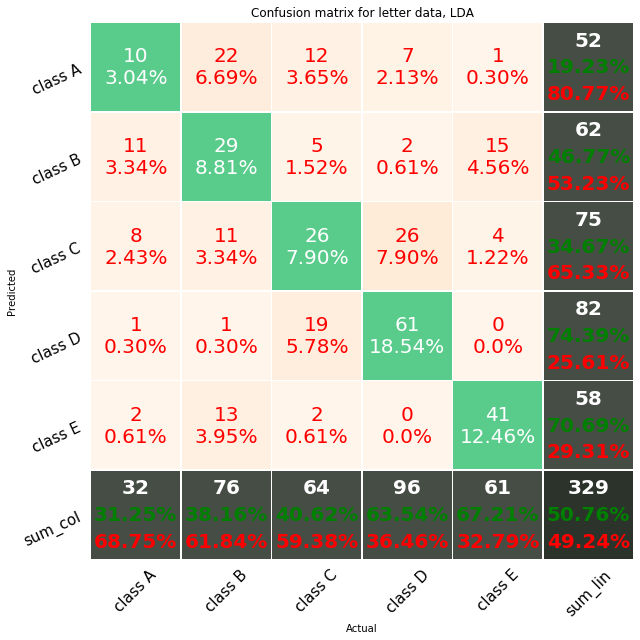

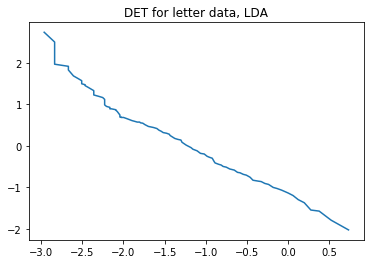

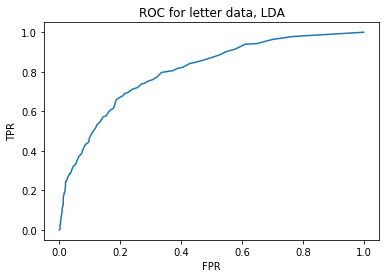

In [16]:
# testing lda

dev_num = np.shape(devdata)[0]
dev_norm = np.zeros((dev_num,dim))
for i in range(dev_num):
    dev_norm[i] = np.subtract(devdata[i,0:dim],mn_train)
dev_pca = pca.transform(dev_norm)
dev_lda = np.zeros((dev_num,cls-1))
for i in range(0,dev_num):
    dev_lda[i] = np.matmul(lda,dev_pca[i])
gnb = GaussianNB()
pred = gnb.fit(train_lda,traindata[:,dim]).predict_proba(dev_lda)
pre = gnb.fit(train_lda,traindata[:,dim]).predict(dev_lda)
    
#print(devdata[:,train_dim],pred)
the_plot_conf(pre,devdata[:,dim],' letter data, LDA')
#p,t = makeit(pred,devdata[:,dim],cls)
#print(makeit(devdata[:,dim]))
DET(pred,makeit(devdata[:,dim]),100,'letter data, LDA')
ROC(pred,makeit(devdata[:,dim]),100,'letter data, LDA')
#plt.show()

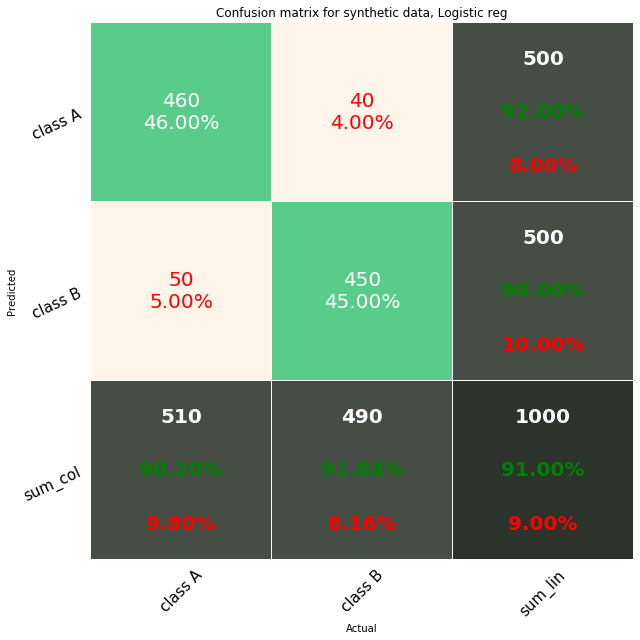

In [31]:
#logistic regression toolkit

logreg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(traindata[:,0:dim],traindata[:,dim])
logpred = logreg.predict(devdata[:,0:dim])
logpred_proba = logreg.predict_proba(devdata[:,0:dim])
the_plot_conf(logpred,devdata[:,dim],' synthetic data, Logistic reg')
#DET(logpred_proba,makeit(devdata[:,dim]),100,'synthetic data, Logistic reg')
#ROC(logpred_proba,makeit(devdata[:,dim]),100,'synthetic data, Logistic reg')


Text(0.5, 1.0, 'Decision boundary for logistic regression synthetic dataset')

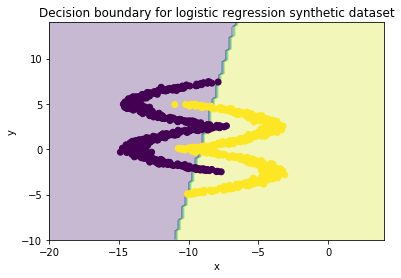

In [31]:


nx,ny = 100,100

y = np.linspace(-10,14,ny)
x = np.linspace(-20,4,nx)
A,B = np.meshgrid(x,y)
z = np.zeros((nx,ny))
for i in range(nx):
    #print(i)
    for j in range(ny):
        z[i,j] = logreg.predict([[A[i,j],B[i,j]]])[0]

        
plt.xlabel("x")
plt.ylabel("y")
#plt.xlim(x_l,x_r)

plt.contourf(A,B,z,alpha=0.3)
plt.scatter(devdata[:,0],devdata[:,1],c =devdata[:,2] )
plt.title("Decision boundary for logistic regression synthetic dataset")
#plt.savefig('NN-synthetic-decision-998-2hidden.jpg')

In [28]:
#logistic regression self implementation


# only for 2 classes

def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))


def log_likelihood(features, target, weights):
    scores = np.dot(features, weights)
    ll = np.sum( target*scores - np.log(1 + np.exp(scores)) )
    return ll


def logistic_regression(features, target, num_steps, learning_rate, add_intercept = False):
    if add_intercept:
        intercept = np.ones((features.shape[0], 1))
        features = np.hstack((intercept, features))
        
    weights = np.zeros(features.shape[1])
    
    for step in range(num_steps):
        scores = np.dot(features, weights)
        predictions = sigmoid(scores)

        output_error_signal = target - predictions
        
        gradient = np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient

        if step % 10000 == 0:
            print (log_likelihood(features, target, weights))
        
    return weights

#traindata = traindata1
#devdata = devdata1
#dim = 2 

#syn data ns = 50000,lr = -5
weights = logistic_regression(traindata[:,0:dim], makeit(traindata[:,dim]),
                     num_steps = 50000, learning_rate = 5e-5, add_intercept=True)



final_scores = np.dot(np.hstack((np.ones((devdata[:,0:dim].shape[0], 1)),
                                 devdata[:,0:dim])), weights)
preds = np.round(sigmoid(final_scores))
print ('Accuracy from scratch: {0}'.format((preds == devdata[:,dim]).sum().astype(float) / len(preds)))

-1881.1008447901352
-458.2660415484355
-456.8330788801096
-456.7628933848048
-456.7586611120156
Accuracy from scratch: 0.04


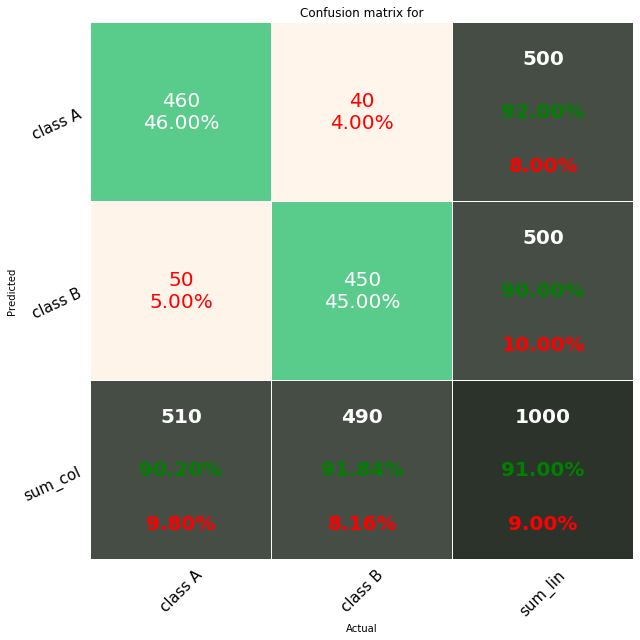

In [29]:
#print(logpred)
#print(preds)
#print(devdata[:,dim])
the_plot_conf(preds,makeit(devdata[:,dim]),'')